<a href="https://colab.research.google.com/github/Donnie-Stewart/Recurrent-Price-Predictor/blob/main/Recurrent_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Recurrent Price Predictor

The purpose of the project is to explore using various Recurrent Neural Networks (RNN) supported by tensorflow, on tabular time series data. Specifically, the task at hand is to predict the next day's high price of Bitcoin based on prior closing date prices. Additionally, I will compare types of RNNs, discussing advantages of each model while implementing them. 

##Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$66,974 per bitcoin. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. I will implement a Recurrent Neural Network model to gain some insight into price prediction. [Yahoo! Finance](https://finance.yahoo.com/quote/BTC-USD/history/ ) is a trusted name in free financial information which I'll be using to gather data to train the RNNs.

The following code cells download the dependencies & training/test data. 

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

In [ ]:
#downloads BTC chart today - can input any valid date 
data = yf.download("BTC-USD", start="2014-09-15", end="2022-01-01")
#for saving and reformatting. 
data.to_csv('BTC-USD.csv')
data = pd.read_csv('BTC-USD.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Plotting the Bitcoin price against dates visualizes the data for this project. The goal is to predict the next day's high price of Bitcoin based on a predetermined look back date. Visualizing can help provide a sanity check to determine how close the model is predicitng to the actual model.   

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13'),
 Text(0, 0, '2021-10-30')]

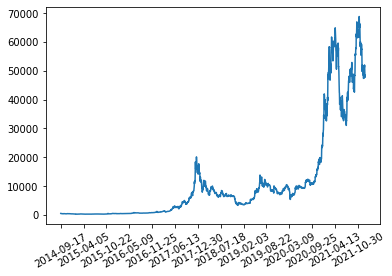

In [5]:
l = len(data)
g = sns.lineplot(x = np.linspace(1,l,l), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,l,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### A) Data Preprocessing
The 5 columns displayed above won't all be necessesary for this project. For predicting the next day's High I will consider only prior daily Highs. 

In [6]:
data_high = data['High'].to_numpy()
data_high = data_high.reshape(-1, 1)


[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn will be used to reformat the data. The current range is from less than \$1 to greater than \$60,000. After scaling, the data is proportionally the same but is in the range 0 to 1. Will need to remember this function later for reverse scaling when predicting. 
- Side note: This is an example of data normalization, preventing any individual number from being overly influential to the system. 

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_high)
data_normalized = scaler.transform(data_high)

I will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, I will simply augment the data so that "time_steps", referring to the number of previous days, are fed to the model at the current time step in order to form a prediction. [Here](https://www.exxactcorp.com/blog/Deep-Learning/recurrent-neural-networks-rnn-deep-learning-for-sequential-data) is more information on autoregressive modeling as well as a justification for LSTM. 

In [8]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [9]:
# Produces a dataset based on the number of days the model could look back
time_steps = 20
X, y = create_dataset(data_normalized, time_steps)

In [11]:
# Check the shape of your dataset; should be (n, time_steps, 1) and (n, 1)
#i.e. n previous data is input -  y is the following day
print(X.shape, y.shape)

(2643, 20, 1) (2643, 1)


### B) Data Partitioning
Split data into train and test sets. Using 80\% for training and 20\% for testing. 

In [15]:
split = ((X.shape[0])*8)//10
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2114, 20, 1) (529, 20, 1) (2114, 1) (529, 1)


For this dataset, I needed to reshape the partitions for the model to be able to process them.

In [16]:
# Reshape input to be [samples, features, timesteps].
X_train = np.reshape(X_train, (X_train.shape[0],1,  X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2114, 1, 20) (529, 1, 20) (2114, 1) (529, 1)


###  C) RNN Model 1: LSTM

In this part I will create a model using an RNN layer (Specifically LSTM) and train it on the training data. I will also plot training and validation loss using mean squared error as your model's metric.

In [ ]:
# Build model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
lstm = tf.keras.models.Sequential([
    LSTM(units = 32, activation = 'relu' , return_sequences = True),     #recurrent activation sigmoid, output activation tanh
    LSTM(units = 64, activation = 'relu' ,return_sequences = True),
    LSTM(units = 128, activation = 'relu' ),
    Dense(units=1)
])
# lstm.summary()
loss = "mean_squared_error"
opt = "adam"
metrics = [MeanSquaredError(), MeanAbsoluteError()]
lstm.compile(optimizer=opt, loss= loss, metrics = metrics)

In [18]:
batchsize = 32
epochs =  30
# Fit model
history = lstm.fit(X_train, y_train, validation_split = .2, epochs=epochs, batch_size=batchsize, verbose = 0)

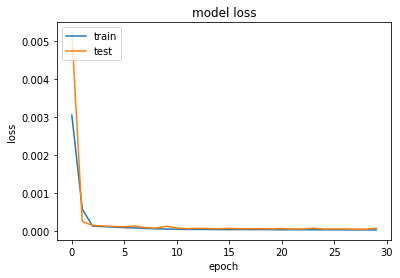

[0.0030514108948409557, 0.0005694805295206606, 0.00012279443035367876, 0.00011297076707705855, 9.749775927048177e-05, 8.421274833381176e-05, 7.769341755192727e-05, 6.515343557111919e-05, 5.352998778107576e-05, 4.7229368647094816e-05, 4.561291279969737e-05, 3.729785748873837e-05, 3.854155875160359e-05, 3.549851317075081e-05, 3.4562785003799945e-05, 3.26493609463796e-05, 3.417179323150776e-05, 3.1600149668520316e-05, 3.40892729582265e-05, 3.1422085157828405e-05, 2.892608245019801e-05, 3.0866875022184104e-05, 2.9167513275751844e-05, 2.977934491354972e-05, 2.8183132599224336e-05, 2.6782334316521883e-05, 2.6159646949963644e-05, 2.475340988894459e-05, 2.5765306418179534e-05, 2.475959263392724e-05]
[0.005233852192759514, 0.0002445350692141801, 0.00014303038187790662, 0.00012845819583162665, 0.00011813497258117422, 0.00010581845708657056, 0.00012724049156531692, 8.468801388517022e-05, 7.111149170668796e-05, 0.00012086513015674427, 7.675852975808084e-05, 5.7660781749291345e-05, 6.63884929963387

In [19]:
# Plot the Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(history.history['loss'])
print(history.history['val_loss'])
print("Final MSE training model loss is:", history.history['loss'][-1])
print("Final MSE validation model loss is:", history.history['val_loss'][-1])

### D) RNN Model 2: GRU
In this part, I will create an RNN model that instead uses a similar structure, GRU, for comparison. 

In [ ]:
# Build model
from tensorflow.keras.layers import GRU, Dropout
gru = tf.keras.models.Sequential([
    GRU(units = 32, activation = 'relu' , return_sequences = True),  
    GRU(units = 64, activation = 'relu' ,return_sequences = True),
    GRU(units = 128, activation = 'relu'),
    Dense(units=1)
])
loss = "mean_squared_error"
opt = "adam"
metrics = [MeanSquaredError(), MeanAbsoluteError()]
gru.compile(optimizer=opt, loss= loss, metrics = metrics)

In [21]:
batchsize = 32
epochs =  60

# Fit model
history = gru.fit(X_train, y_train, validation_split = .2, epochs=epochs, batch_size=batchsize, verbose = 0)

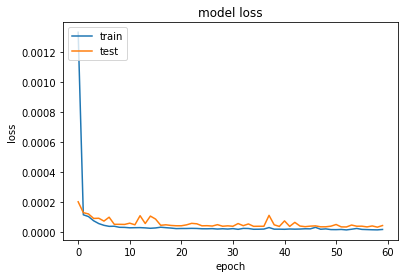

[0.001333520282059908, 0.00011788093252107501, 0.00010595640924293548, 7.795543206157163e-05, 5.919947579968721e-05, 4.764654295286164e-05, 4.0866976632969454e-05, 4.154067573836073e-05, 3.451843076618388e-05, 3.393289080122486e-05, 3.117513551842421e-05, 3.1902258342597634e-05, 3.2383628422394395e-05, 3.066410863539204e-05, 2.7998039513477124e-05, 3.023591489181854e-05, 3.5119446692988276e-05, 3.207785266567953e-05, 2.9387842005235143e-05, 2.5864161216304637e-05, 2.6532094125286676e-05, 2.6615218303049915e-05, 2.7471291105030105e-05, 2.6809399059857242e-05, 2.4802433472359553e-05, 2.457727532600984e-05, 2.5655323042883538e-05, 2.2826221538707614e-05, 2.4886323444661684e-05, 2.276029044878669e-05, 2.5729726985446177e-05, 2.1029360141255893e-05, 2.7224681616644375e-05, 2.653030060173478e-05, 2.1401760022854432e-05, 2.173430402763188e-05, 2.2725362214259803e-05, 3.2898347853915766e-05, 2.2015508875483647e-05, 2.2062904463382438e-05, 2.1253128579701297e-05, 2.3191505533759482e-05, 2.21057

In [22]:
# Plot the Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(history.history['loss'])
print(history.history['val_loss'])
print("Final MSE training model loss is:", history.history['loss'][-1])
print("Final MSE validation model loss is:", history.history['val_loss'][-1])

### E) Looking at the Predictions

Now, I will display my best model's performance on the test set, plotting the model's prediction for Bitcoin Price along with the actual test set prices. 

**Note:** The model is trained on normalized data and thus predicts a normalized score. In order to transform the model's predictions to the original price range will have to use sklearn's [inverse_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

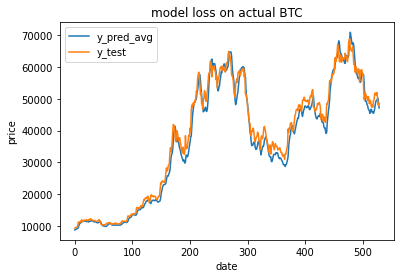

In [25]:
# y_pred_gru =  scaler.inverse_transform(gru.predict(X_test)) 
# y_pred_lstm = scaler.inverse_transform(lstm.predict(X_test))
y_pred_avg =  (scaler.inverse_transform(gru.predict(X_test)) +scaler.inverse_transform(lstm.predict(X_test)))/2
y_test2 =  scaler.inverse_transform(y_test)
# plt.plot(y_pred_gru)
# plt.plot(y_pred_lstm)
plt.plot(y_pred_avg)
plt.plot(y_test2)
plt.title('model loss on actual BTC')
plt.ylabel('price')
plt.xlabel('date')
plt.legend([ 'y_pred_avg', 'y_test'], loc='upper left')
plt.show()

After testing lookback days , layer amount, dropout, and different architectures, I (by coincidence) made a GRU that undershoots the price and an LSTM that overshoots it, and taking the average of their prediction proved to be closest to the actual bitcoin prices. 20 look back days was empirically the best for my architectures. It potentially was never the right complexity when I tested a higher amount of look back days (up to 100). Layer amount of three seemed to be the best for both the GRU and LSTM that I tested. The GRU usually provided lower losses but because these models were working with fractional squared loss, the LSTM may have performed better with other metrics like absolute error. Thus the best model I found was actually a combination of both GRU and LSTM. 

